# CEO-Request Challenge


🕵🏻 **Should Olist remove underperforming sellers from its marketplace ?**

## Problem statement

🕵🏻 To analyse the impact of removing the worse sellers from Olist's marketplace, we can start with a what-if analysis: What would have happened if Olist had never accepted these sellers in the first place? For that:

1️⃣ Compute, for each `seller_id`, and cumulated since the beginning:
- the `revenues` it brings
- the `costs` associated with all its bad reviews
- the resulting `profits` (revenues - costs)
- the number of `orders` (it will impact the overall IT costs)


2️⃣ We can then:
- sort sellers by increasing profits for Olist
- for each number of sellers to remove, compute the financial impact it would have made if they had never been accepted on the platform. 
- we may find an optimal number of sellers to remove that maximizes Olist's profit margin

In [9]:
%load_ext autoreload
%autoreload 2
import pandas as pd 
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns 
from olist.data import Olist
from olist.order import Order
from olist.seller import Seller
seller = Seller().get_training_data()
order = Order().get_training_data()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
seller

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profits
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,0.333333,0.333333,3.00,140,3,3,1.000,218.70,341.870,201.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,0.050000,0.725000,4.55,240,40,41,1.025,11703.07,2290.307,2050.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,0.000000,1.000000,5.00,0,1,1,1.000,158.00,15.800,15.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,0.000000,1.000000,5.00,0,1,1,1.000,79.99,7.999,7.999
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1.000000,0.000000,1.00,100,1,1,1.000,167.99,16.799,-83.201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2962,98dddbc4601dd4443ca174359b237166,sarandi,PR,0.000000,8.230822,2018-07-14 03:10:19,2018-07-23 15:34:03,0.0,0.000000,1.000000,5.00,0,2,2,1.000,158.00,15.800,15.800
2963,f8201cab383e484733266d1906e2fdfa,palhoca,SC,0.000000,13.045797,2017-06-17 15:30:11,2018-08-11 19:55:17,14.0,0.100000,0.500000,4.10,140,10,10,1.000,889.00,1208.900,1068.900
2964,74871d19219c7d518d0090283e03c137,sao paulo,SP,0.000000,3.606625,2018-04-05 17:09:46,2018-08-21 19:25:15,5.0,0.000000,1.000000,5.00,0,6,6,1.000,550.04,455.004,455.004
2965,e603cf3fec55f8697c9059638d6c8eb5,pelotas,RS,0.000000,6.657634,2017-02-09 02:43:17,2017-06-16 17:30:16,4.0,0.000000,0.500000,4.25,50,8,8,1.000,297.00,349.700,299.700


In [71]:
order

,cost_of_reviews
seller_id,
0015a82c2db000af6aaaf3ae2ecb0532,100
001cca7ae9ae17fb1caed9dfb1094831,4250
002100f778ceb8431b7a1020ff7ab48f,1010
003554e2dce176b5555353e4f3555ac8,0
004c9cd9d87a3c30c522c48c4fc07416,2610
...,...
ffc470761de7d0232558ba5e786e57b7,400
ffdd9f82b9a447f6f8d4b91554cc7dd3,240
ffeee66ac5d5a62fe688b9d26f83f534,200


In [13]:
final_df = pd.DataFrame()
revenus_df = pd.DataFrame()
#Product price qui correspond à la commission de olist
#on applique 10% sur le prix du produit = commission
revenus_df = seller[['seller_id','sales','n_orders','date_first_sale','date_last_sale','review_score']]
revenus_df['Olist Product Price'] = revenus_df.loc[:,'sales']*0.1 
revenus_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2967 entries, 0 to 2966
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   seller_id            2967 non-null   object        
 1   sales                2967 non-null   float64       
 2   n_orders             2967 non-null   int64         
 3   date_first_sale      2967 non-null   datetime64[ns]
 4   date_last_sale       2967 non-null   datetime64[ns]
 5   review_score         2967 non-null   float64       
 6   Olist Product Price  2967 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(1), object(1)
memory usage: 185.4+ KB


/var/folders/5t/r6_mkf0x1zl9f1rvdldpw7pr0000gn/T/ipykernel_47526/99588358.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  revenus_df['Olist Product Price'] = revenus_df.loc[:,'sales']*0.1


In [5]:
#charge by month per seller of Olist
revenus_df['charges_by_month'] = -(revenus_df['date_first_sale'] - revenus_df['date_last_sale'])/ datetime.timedelta(days= 30)
revenus_df['charges_by_month'].value_counts()
revenus_df['charges_by_month'] = revenus_df['charges_by_month'].apply(lambda x : (int(x) + 1) * 80)
revenus_df['charges_by_month']

/var/folders/5t/r6_mkf0x1zl9f1rvdldpw7pr0000gn/T/ipykernel_41286/325759479.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  revenus_df['charges_by_month'] = -(revenus_df['date_first_sale'] - revenus_df['date_last_sale'])/ datetime.timedelta(days= 30)
/var/folders/5t/r6_mkf0x1zl9f1rvdldpw7pr0000gn/T/ipykernel_41286/325759479.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  revenus_df['charges_by_month'] = revenus_df['charges_by_month'].apply(lambda x : (int(x) + 1) * 80)


0        320
1       1200
2         80
3         80
4         80
        ... 
2962      80
2963    1200
2964     400
2965     400
2966      80
Name: charges_by_month, Length: 2967, dtype: int64

In [6]:
total_profit = revenus_df['Olist Product Price']  + revenus_df['charges_by_month'] 

In [9]:
# cost of reviews
#order=[['order_id','review_score']]
def review_score(x):
    if x == 1:
        return 100
    if x == 2 :
        return 50
    if x == 3 :
        return 40
    else:
        return 0
order['cost_of_reviews']= order['review_score'].apply(review_score)

In [10]:
order['cost_of_reviews']

0         0
1         0
2         0
3         0
4         0
         ..
96356     0
96357     0
96358     0
96359    50
96360     0
Name: cost_of_reviews, Length: 96353, dtype: int64

In [11]:
data = Olist().get_data()
order_seller = data['order_items']
order_seller = order_seller[['order_id','seller_id']]

In [12]:
order = order.merge(order_seller,on = 'order_id')
order = order.groupby('seller_id').sum()[['cost_of_reviews']]
order.head()

,cost_of_reviews
seller_id,
0015a82c2db000af6aaaf3ae2ecb0532,100
001cca7ae9ae17fb1caed9dfb1094831,4250
002100f778ceb8431b7a1020ff7ab48f,1010
003554e2dce176b5555353e4f3555ac8,0
004c9cd9d87a3c30c522c48c4fc07416,2610


# Cost It

In [13]:
# Cost 
def computes_cost(df):
    return 500_000 / np.sum(np.sqrt(df['orders']))* np.sqrt(df['orders'])
#les coûts informatiques d'Olist (augmentent avec le nombre de commandes traitées),de facon décroissante.effets d'échelles
#Depuis la naissance de la marketplace, les coûts informatiques cumulés s'élèvent à 500 000 BRL.

# Profit

In [ ]:
# Profit
seller['t_profit'] = revenus_df['Olist Product Price']  + revenus_df['charges_by_month']
seller['t_profit_string'] = ""
def total_profit(df,profits_min):
    for i in range(len(df.t_profit)):
        if df.loc[i, 't_profit'] > 0:
            df.loc[i,'t_profit_string'] = "positif"
        if df.loc[i, 't_profit'] <= 0:
            df.loc[i,'t_profit_string'] = "not sufficient"
    return

In [55]:
total_profit(seller,100)

In [ ]:
plt.figure(figsize = (13,3))
plt.subplot(1,2,1)
sns.barplot(x="t_profit", y="profits", data=seller)

In [ ]:
drop_sellers = n_sorted_sellers.head(1000)
keep_sellers = n_sorted_sellers.tail(1000)
drop_sellers['profit'].sum()

In [ ]:
new_profits = keep_sellers.profit.sum()

<AxesSubplot:ylabel='profits'>

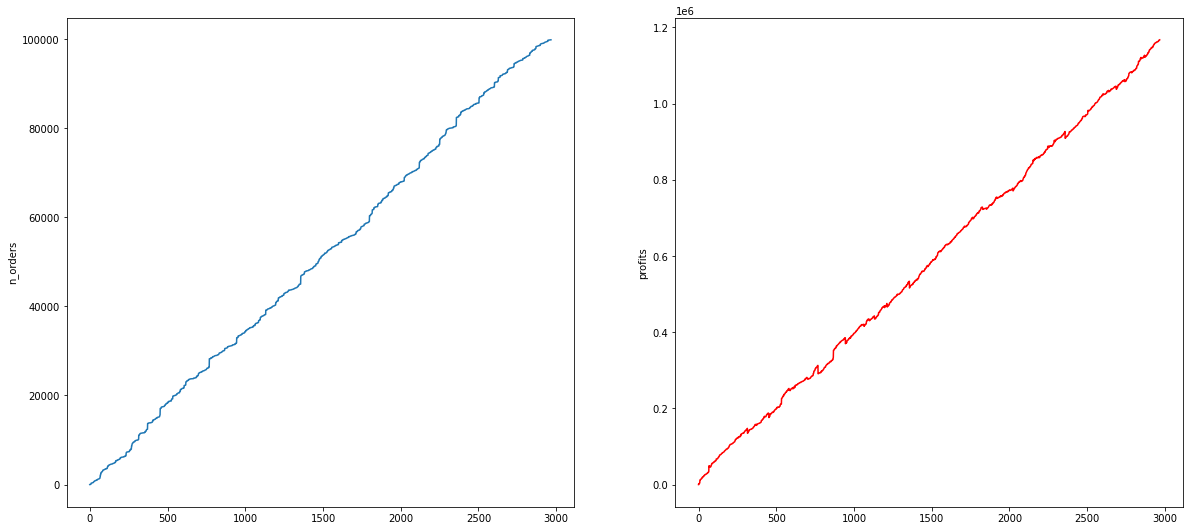

In [114]:
num_orders = s['n_orders'].cumsum()[-1:]
fig,axs = plt.subplots(1,2,figsize=(20,9))

sns.lineplot(data=s["n_orders"].cumsum(), ax = axs[0]) ;
sns.lineplot(data=s["profits"].cumsum(), ax= axs[1],color= 'red')

In [ ]:
plt.subplot(1,2,2)
sns.barplot(x="t_profit", y="n_orders", data=seller);

----- Distribution of cost_of_reviews : -----


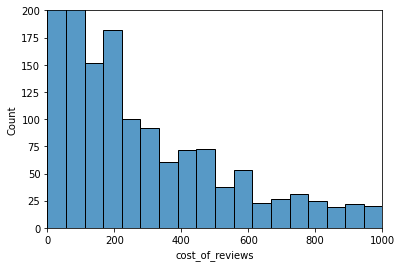

In [101]:
for variable in order.select_dtypes(exclude = ["object"]).columns:
    plt.ylim((0,200))
    plt.xlim((0,1000))
    print(f"----- Distribution of {variable} : -----")
    sns.histplot(order[variable])
    plt.show()
    

# Plot


Text(0.5, 0, 'seller id')

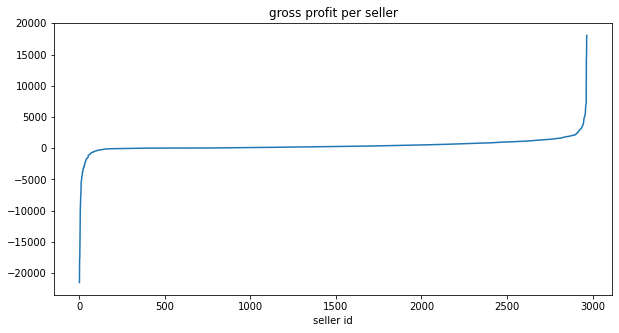

In [78]:
sorted_seller = seller.sort_values(by='profits')[['profits', 'n_orders', 'revenues']].reset_index()
sorted_seller.head()

plt.figure(figsize=(10,5))
sorted_seller.profits.plot()
plt.title('gross profit per seller')
plt.xlabel('seller id')

In [81]:
#l'objectif est de plotter le temps d'attente(en j) selon le temps que prends le seller (vers le transporteur),
#observations plus le temps d'attente est long plus la note attribué est basse
import plotly.express as px
fig = px.scatter(data_frame = seller[seller['review_score'] < 4],
    x="wait_time",
    y="delay_to_carrier",
    size="sales",
    color="review_score",
    size_max = 60,
    opacity = 0.5
)
fig.show()

In [84]:
import plotly.express as px
fig = px.scatter(data_frame = seller[seller['review_score'] < 4],
    x="n_orders",
    y="profits",
    size="sales",
    color="review_score",
    size_max = 60,
    opacity = 0.5
)
fig.show()


<AxesSubplot:ylabel='profits'>

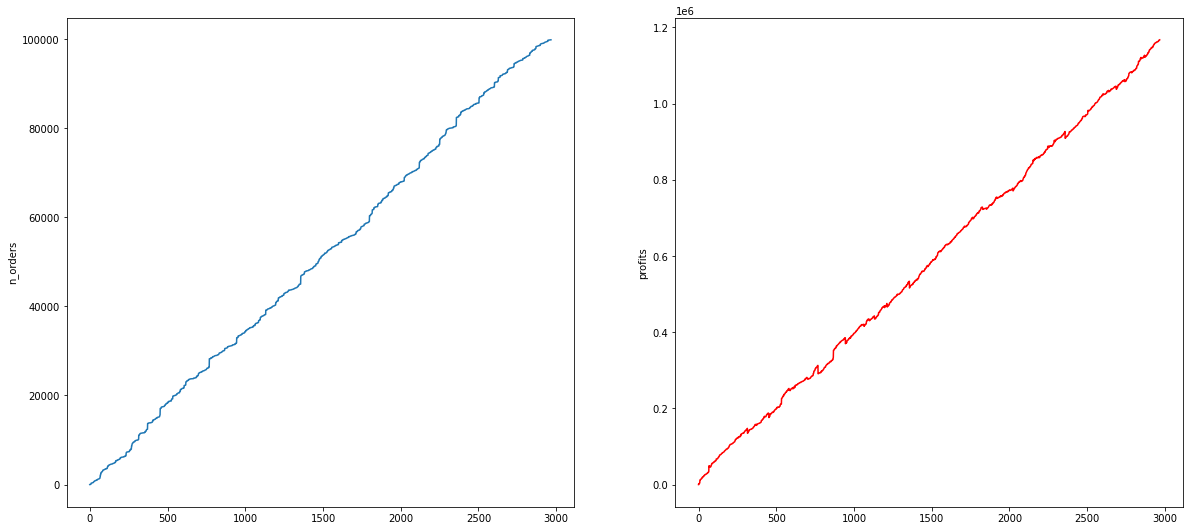

In [113]:
num_orders = s['n_orders'].cumsum()[-1:]
fig,axs = plt.subplots(1,2,figsize=(20,9))

sns.lineplot(data=s["n_orders"].cumsum(), ax = axs[0]) ;
sns.lineplot(data=s["profits"].cumsum(), ax= axs[1],color= 'red')

In [ ]:
new_profits = keep_sellers.profit.sum()

In [15]:
%%bash
jupyter nbconvert my_slideshow_CEO.ipynb --to slides --post serve \
--no-prompt \
--TagRemovePreprocessor.remove_input_tags=remove_input \
--TagRemovePreprocessor.remove_all_outputs_tags=remove_output


This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the notebook prior to export.
    Equivalent to: [--ExecutePr

[NbConvertApp] WARNING | pattern 'my_slideshow_CEO.ipynb' matched no files


CalledProcessError: Command 'b'jupyter nbconvert my_slideshow_CEO.ipynb --to slides --post serve \\\n--no-prompt \\\n--TagRemovePreprocessor.remove_input_tags=remove_input \\\n--TagRemovePreprocessor.remove_all_outputs_tags=remove_output\n'' returned non-zero exit status 255.

👉 Write down a detailed strategy (step by step) to create the DataFrame you need for the first step.

💡Think about how to re-use or update the logic you've already coded in your 🗂 `olist` package

<details>
    <summary>- <i>Hints</i> -</summary>


Starting from your current `seller().get_training_data()` DataFrame, can you easily transform it to compute:
- Olist's positive `revenue_per_seller`? 
- Olist's `cost_of_bad_reviews`?

⚠️ Do no start from scratch ! Investigate your source code in `seller.py` : 
- how was the mean `review_score` per seller computed? 
- Can you think about  a way to update your code to incorporate the `cost_of_reviews`? 

</details>


## Your turn!

🧺 Keep this notebook tidy! 

📅 🗣 📊 You will present your insights to Olist's CEO next time, after the `Communicate your Data Analysis insights` day!